In [ ]:
import numpy as np
import scipy.signal as signal
import os
import glob
import matplotlib.pyplot as plt
from scipy.io import savemat
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define constants
sampling_rate = 173.61  # Hz
low_cutoff = 0.5  # Hz
high_cutoff = 50  # Hz
order = 5  # Filter order

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Bandpass filter design
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

In [ ]:
# Load and preprocess EEG data
def preprocess_eeg(folder_path):
    file_paths = sorted(glob.glob(os.path.join(folder_path, "*.txt")) + glob.glob(os.path.join(folder_path, "*.TXT")))
    processed_data = []

    for file_path in file_paths:
        data = np.loadtxt(file_path)  # Load EEG signal
        data = butter_bandpass_filter(data, low_cutoff, high_cutoff, sampling_rate, order)  # Apply filtering
        data = (data - np.mean(data)) / np.std(data)  # Normalize to zero mean, unit variance
        processed_data.append(data)

    return np.array(processed_data)

Processed and saved F dataset at /content/drive/MyDrive/EEG Dataset/Processed/processed_F.mat
Processed and saved N dataset at /content/drive/MyDrive/EEG Dataset/Processed/processed_N.mat
Processed and saved O dataset at /content/drive/MyDrive/EEG Dataset/Processed/processed_O.mat
Processed and saved S dataset at /content/drive/MyDrive/EEG Dataset/Processed/processed_S.mat
Processed and saved Z dataset at /content/drive/MyDrive/EEG Dataset/Processed/processed_Z.mat


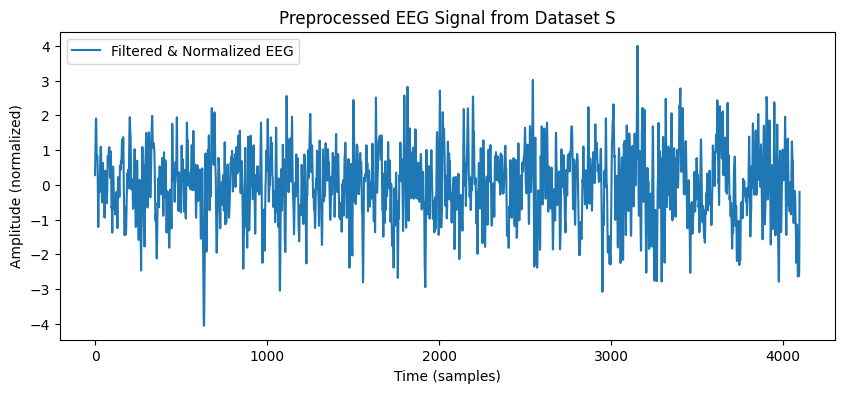

In [ ]:
# Google Drive base path where EEG folders (A-E) are stored
data_base_folder = "/content/drive/MyDrive/EEG Dataset"
data_folders = ['F', 'N', 'O', 'S', 'Z']  # List of folders

# Create the 'Processed' directory if it doesn't exist
processed_dir = os.path.join(data_base_folder, "Processed")
os.makedirs(processed_dir, exist_ok=True) # This will create 'Processed' if it's not there

# Process each folder and save separately
for folder in data_folders:
    folder_path = os.path.join(data_base_folder, folder)
    processed_eeg = preprocess_eeg(folder_path)

    # Save processed data
    save_path = os.path.join(processed_dir, f"processed_{folder}.mat") # Changed to use os.path.join
    savemat(save_path, {"eeg_data": processed_eeg})

    print(f"Processed and saved {folder} dataset at {save_path}")

# Plot an example signal from one dataset (e.g., A)
plt.figure(figsize=(10, 4))
plt.plot(processed_eeg[0], label="Filtered & Normalized EEG")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (normalized)")
plt.title("Preprocessed EEG Signal from Dataset S")
plt.legend()
plt.show()

In [ ]:
processed_eeg_N = preprocess_eeg("/content/drive/MyDrive/EEG Dataset/N")
savemat("/content/drive/MyDrive/EEG Dataset/Processed/processed_N.mat", {"eeg_data": processed_eeg_N})


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.io import loadmat
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

In [ ]:
# Load preprocessed EEG data from Google Drive
data_base_folder = "/content/drive/MyDrive/EEG Dataset/Processed"
data_folders = ['F', 'N', 'O', 'S', 'Z']

# Map EEG classes to three categories
label_map = {"F": 0, "N": 0, "O": 1, "Z": 1, "S": 2}  # Three-class classification

def load_data():
    X, y = [], []

    for folder in data_folders:
        file_path = os.path.join(data_base_folder, f"processed_{folder}.mat")

        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found. Skipping...")
            continue

        mat_data = loadmat(file_path)
        if 'eeg_data' not in mat_data:
            print(f"Warning: 'eeg_data' key missing in {file_path}. Skipping...")
            continue

        eeg_signals = mat_data['eeg_data']
        if eeg_signals.size == 0:
            print(f"Warning: {file_path} contains no data. Skipping...")
            continue

        X.append(eeg_signals)
        y.append(np.full((eeg_signals.shape[0],), label_map[folder]))

    if not X:
        raise ValueError("No valid EEG data found. Please check the dataset.")

    X = np.vstack(X)
    y = np.concatenate(y)

    return X, y

In [ ]:
# Load dataset
X, y = load_data()

# Normalize dataset (zero mean, unit variance as per paper)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define CNN-LSTM model based on research paper
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=256, kernel_size=3, activation='relu'),  # Additional conv layer
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        LSTM(64, return_sequences=True),  # First LSTM layer
        LSTM(32, return_sequences=False),  # Second LSTM layer
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)                   │ (None, 4095, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 2047, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_33 (Conv1D)                   │ (None, 2045, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 1022, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 236,171 (922.55 KB)

 Trainable params: 78,723 (307.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 157,448 (615.04 KB)

In [ ]:
# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
all_y_true, all_y_pred = [], []

fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nTraining Fold {fold}/10...")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_cnn_lstm_model(input_shape=X_train.shape[1:], num_classes=3)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,  # Now fixed to 50 per fold
        batch_size=16,  # Smaller batch size per research paper
        class_weight=class_weight_dict  # Balance class weights
    )

    y_pred = np.argmax(model.predict(X_test).astype(np.float32), axis=1)
    accuracies.append(model.evaluate(X_test, y_test, verbose=0)[1])
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {accuracies[-1]:.4f}")
    fold += 1


Training Fold 1/10...
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.5786 - loss: 0.9925 - val_accuracy: 0.4400 - val_loss: 1.0930
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7205 - loss: 0.8156 - val_accuracy: 0.4400 - val_loss: 1.3126
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7748 - loss: 0.7033 - val_accuracy: 0.4400 - val_loss: 1.5762
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8111 - loss: 0.5339 - val_accuracy: 0.4400 - val_loss: 1.6989
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8265 - loss: 0.5121 - val_accuracy: 0.4400 - val_loss: 2.0545
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8810 - loss: 0.4558 - val_accuracy: 0.4400 - val_loss: 2.1992
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9397 - loss: 0.2963 - val_accuracy: 0.4600 - val_loss: 2.1027
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8373 - loss: 0.4324 - v

In [ ]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities instead of class labels
y_probs = model.predict(X)  # Get probabilities for each class

# Calculate AUC using predicted probabilities
auc = roc_auc_score(y, y_probs, multi_class='ovr')
print(f"\nAUC Score: {auc:.4f}")
# Print final classification report
print("\nFinal Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=["Intermittent Epilepsy", "Healthy", "Continuous Epilepsy"]))

# Save trained model
model.save("/content/drive/MyDrive/cnn_lstm_trained_model.h5")
print("CNN-LSTM model trained, evaluated, and saved with 10-fold cross-validation.")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step



AUC Score: 0.9978

Final Classification Report:
                       precision    recall  f1-score   support

Intermittent Epilepsy       0.97      0.93      0.95       200
              Healthy       0.93      0.97      0.95       200
  Continuous Epilepsy       0.92      0.92      0.92       100

             accuracy                           0.94       500
            macro avg       0.94      0.94      0.94       500
         weighted avg       0.94      0.94      0.94       500

CNN-LSTM model trained, evaluated, and saved with 10-fold cross-validation.


In [ ]:
# Define CNN-LSTM model based on research paper
def create_cnn_lstm_model_2(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=256, kernel_size=3, activation='relu'),  # Additional conv layer
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        LSTM(128, return_sequences=True, dropout=0.2),  # First LSTM layer
        LSTM(64, return_sequences=False, dropout=0.2),  # Second LSTM layer
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_109 (Conv1D)                  │ (None, 4095, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 4095, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_109 (MaxPooling1D)     │ (None, 2047, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_110 (Conv1D)                  │ (None, 2045, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 2045, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_110 (MaxPooling1D)     │ (None, 1022, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_111 (Conv1D)                  │ (None, 1020, 256)           │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 1020, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_111 (MaxPooling1D)     │ (None, 510, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_67 (LSTM)                       │ (None, 510, 64)             │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_68 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,843 (2.54 MB)

 Trainable params: 221,315 (864.51 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 442,632 (1.69 MB)

In [ ]:
# Learning Rate Scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
all_y_true, all_y_pred = [], []

fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nTraining Fold {fold}/10...")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_cnn_lstm_model(input_shape=X_train.shape[1:], num_classes=3)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,  # Increased from 80 to 100
        batch_size=32,  # Adjusted batch size as per research paper
        class_weight=class_weight_dict,  # Balance class weights
        callbacks=[lr_scheduler]  # Added learning rate decay
    )

    y_pred = np.argmax(model.predict(X_test).astype(np.float32), axis=1)
    accuracies.append(model.evaluate(X_test, y_test, verbose=0)[1])
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold {fold} Accuracy: {accuracies[-1]:.4f}")
    fold += 1


Training Fold 1/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.5710 - loss: 0.9385 - val_accuracy: 0.4600 - val_loss: 1.0480 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7283 - loss: 0.7605 - val_accuracy: 0.4400 - val_loss: 1.1489 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7862 - loss: 0.6120 - val_accuracy: 0.4400 - val_loss: 1.4665 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8349 - loss: 0.5021 - val_accuracy: 0.4400 - val_loss: 1.8331 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8996 - loss: 0.3728 - val_accuracy: 0.4400 - val_loss: 2.1370 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9079 - loss: 0.3508 - val_accuracy: 0.4400 - val_loss: 2.2405 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9113 - loss: 0.3302 -

In [ ]:
# Compute AUC Score
y_probs = model.predict(X)  # Get probabilities for each class

# Check the shape of y_probs
print("Shape of y_probs:", y_probs.shape)

# Calculate AUC using predicted probabilities
auc = roc_auc_score(y, y_probs, multi_class='ovr')
print(f"\nAUC Score: {auc:.4f}")

# Print final classification report
print("\nFinal Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=["Intermittent Epilepsy", "Healthy", "Continuous Epilepsy"]))

# Save trained model
model.save("/content/drive/MyDrive/cnn_lstm_trained_model_2.h5")
print("CNN-LSTM model trained, evaluated, and saved with 10-fold cross-validation.")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Shape of y_probs: (500, 3)

AUC Score: 0.9995

Final Classification Report:
                       precision    recall  f1-score   support

Intermittent Epilepsy       0.95      0.95      0.95       200
              Healthy       0.94      0.96      0.95       200
  Continuous Epilepsy       0.96      0.92      0.94       100

             accuracy                           0.95       500
            macro avg       0.95      0.94      0.95       500
         weighted avg       0.95      0.95      0.95       500

CNN-LSTM model trained, evaluated, and saved with 10-fold cross-validation.
